In [2]:
%pip install prince
import prince
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations   
from itertools import product  
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import bootstrap
from scipy.spatial import distance
from numpy.linalg import inv
from scipy.stats import chi2
import Bootstrap as bt

### Manejo que se hizo con el DataFrame original

* Se categorizó la variable MMSE de la siguiente manera:
    * 30-27 puntos: Sin deterioro
    * 26-25 puntos: Dudoso o posible deterioro
    * 24-10 puntos: Deterioro leve a moderado
    * 9-6 puntos: Demencia moderada a severa
    * Menos de 6 puntos: Demencia severa.
* Se categorizó la variable AGE en la siguiente manera:
    * 60-69 años
    * 70-79 años
    * 80-90 años


In [56]:
df1 = pd.read_csv("Base_definitiva_2.0.csv")
pos = 0
# Agrupamiento de edades
for data in df1["Age"]:
    if data < 70:
        df1["Age"][pos] = "60-69"
    elif data >= 70 and data < 80:
        df1["Age"][pos] = "70-79"
    elif data >= 80 and data <= 90:
        df1["Age"][pos] = "80-90"
    pos += 1
df1["Age"] = df1["Age"].astype("category")

# Agrupamiento de MMSE
pos = 0
for data in df1["MMSE"]:
    if data >= 27:
        df1["MMSE"][pos] = "Sin deterioro"
    elif data >= 25 and data < 27:
        df1["MMSE"][pos] = "Posible deterioro"
    elif data >= 10 and data < 25:
        df1["MMSE"][pos] = "Deterioro leve"
    elif data >= 6 and data < 10:
        df1["MMSE"][pos] = "Deterioro moderado"
    elif data < 6:
        df1["MMSE"][pos] = "Demencia severa"
    pos += 1
df1["MMSE"] = df1["MMSE"].astype("category")
print(df1["Age"].value_counts())
print(df1["MMSE"].value_counts())

#Eliminar filas con datos faltantes
#print(len(df))
#df = df.dropna()
#print(len(df))
#print(df["Age"].value_counts())
#print(df["MMSE"].value_counts())
#df.to_csv(Path("Base_buena.csv", index=False))

Age
80-90    745
70-79    703
60-69    701
Name: count, dtype: int64
MMSE
Deterioro leve        796
Sin deterioro         693
Demencia severa       289
Deterioro moderado    237
Posible deterioro     134
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_36344\1130567404.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1["Age"][pos] = "70-79"
C:\Users\user\AppData\Local\Temp\ipykernel_36344\1130567404.py:8: SettingWithCopyWarning: 
A value is t

### Base de datos a usar

In [3]:
df = pd.read_csv("Base_buena.csv")

In [23]:
categoricas = ["Age","Gender","MMSE","LocationDesc"]
numericas = ["CholesterolLDL","CholesterolHDL"]
print(df["MMSE"].unique())

['Sin deterioro' 'Demencia severa' 'Deterioro leve' 'Deterioro moderado'
 'Posible deterioro']


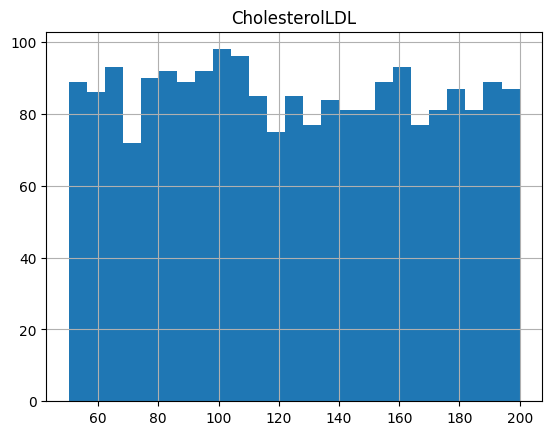

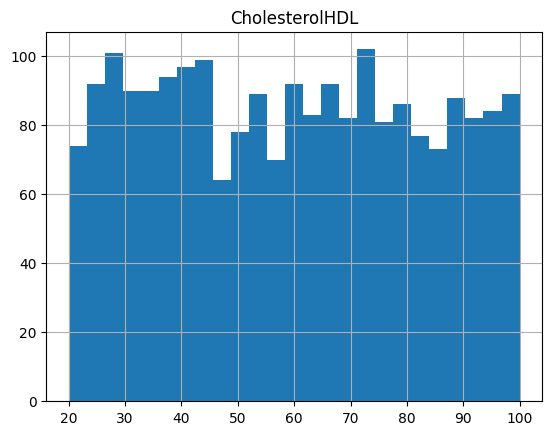

In [59]:
#[df[c].hist(bins=round(np.sqrt(len(df)))) for c in columns_interes]; plt.show()
for col in numericas:
  #df[col].hist(bins=round(np.sqrt(len(df)))); plt.title(col); plt.show()
  df[col].hist(bins=25); plt.title(col); plt.show()

In [60]:
df.corr()

ValueError: could not convert string to float: '70-79'

## Bootstrap

In [61]:
df = pd.read_csv("Base_buena.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,Age,Gender,FamilyHistoryAlzheimers,HeadInjury,Diabetes,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,State
0,0,0,70-79,0,0,0,1,242.366840,56.150897,33.682564,162.189143,Sin deterioro,California
1,1,1,80-90,0,0,0,0,231.162595,193.407995,79.028477,294.630909,Demencia severa,Arkansas
2,2,2,70-79,0,1,0,0,284.181858,153.322762,69.772292,83.638324,Deterioro leve,Nebraska
3,3,3,70-79,1,0,0,0,159.582240,65.366637,68.457491,277.577358,Sin deterioro,Vermont
4,4,4,80-90,0,0,0,0,237.602184,92.869700,56.874305,291.198780,Sin deterioro,California


In [62]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,Gender,FamilyHistoryAlzheimers,HeadInjury,Diabetes,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,1074.000000,1074.000000,0.506282,0.252210,0.092601,0.150768,225.197519,124.335944,59.463533,228.281496
std,620.507185,620.507185,0.500077,0.434382,0.289940,0.357906,42.542233,43.366584,23.139174,101.986721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.093316,50.230707,20.003434,50.407194
25%,537.000000,537.000000,0.000000,0.000000,0.000000,0.000000,190.252963,87.195798,39.095698,137.583222
50%,1074.000000,1074.000000,1.000000,0.000000,0.000000,0.000000,225.086430,123.342593,59.768237,230.301983
75%,1611.000000,1611.000000,1.000000,1.000000,0.000000,0.000000,262.031657,161.733733,78.939050,314.839046
max,2148.000000,2148.000000,1.000000,1.000000,1.000000,1.000000,299.993353,199.965665,99.980324,399.941862


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0.1,2149.0,1074.000000,620.507185,0.000000,537.000000,1074.000000,1611.000000,2148.000000
Unnamed: 0,2149.0,1074.000000,620.507185,0.000000,537.000000,1074.000000,1611.000000,2148.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
FamilyHistoryAlzheimers,2149.0,0.252210,0.434382,0.000000,0.000000,0.000000,1.000000,1.000000
HeadInjury,2149.0,0.092601,0.289940,0.000000,0.000000,0.000000,0.000000,1.000000
Diabetes,2149.0,0.150768,0.357906,0.000000,0.000000,0.000000,0.000000,1.000000
CholesterolTotal,2149.0,225.197519,42.542233,150.093316,190.252963,225.086430,262.031657,299.993353
CholesterolLDL,2149.0,124.335944,43.366584,50.230707,87.195798,123.342593,161.733733,199.965665
CholesterolHDL,2149.0,59.463533,23.139174,20.003434,39.095698,59.768237,78.939050,99.980324
CholesterolTriglycerides,2149.0,228.281496,101.986721,50.407194,137.583222,230.301983,314.839046,399.941862


### ANOVA

In [64]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolLDL ~ C(State)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.10,
    seed=42,
    progress=True
)


resumen


,F_obs,p_boot,q_0.90,CI_low,CI_high
C(State),320.117218,0.851,339.291414,315.160523,342.188034


In [51]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolHDL ~ C(Age)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.10,
    seed=42,
    progress=True
)


resumen


,F_obs,p_boot,q_0.90,CI_low,CI_high
C(Age),1.271943,0.637,4.857591,0.191175,5.998343


In [45]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolLDL ~ C(Age)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.10,
    seed=42,
    progress=True
)


resumen

,F_obs,p_boot,q_0.90,CI_low,CI_high
C(Age),0.257226,0.818,2.902025,0.064657,3.880203


In [53]:
pg.pairwise_tukey(dv='CholesterolHDL', between='Age', data=df) #Siempre es la celda, no cada columna por separado

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,60-69,70-79,58.979443,60.602409,-1.622966,1.234923,-1.314225,0.387349,-0.069531
1,60-69,80-90,58.979443,58.844362,0.135081,1.217418,0.110957,0.993236,0.005881
2,70-79,80-90,60.602409,58.844362,1.758048,1.216526,1.445138,0.317954,0.075979


In [ ]:
pg.pairwise_tukey(dv='CholesterolLDL', between='State', data=df) #Siempre es la celda, no cada columna por separado
signif = df_tukey[df_tukey['p-tukey'] < 0.05].sort_values('hedges', ascending=False)
print(signif)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Alabama,Alaska,179.864148,74.899520,104.964628,2.907807,36.097527,0.0,7.527261
1,Alabama,Arizona,179.864148,131.482085,48.382062,2.824528,17.129258,0.0,3.190364
2,Alabama,Arkansas,179.864148,179.516712,0.347436,2.991369,0.116146,1.0,0.026851
3,Alabama,California,179.864148,76.977427,102.886720,3.244772,31.708460,0.0,7.409981
4,Alabama,Colorado,179.864148,73.221322,106.642826,3.189253,33.438180,0.0,8.010307
...,...,...,...,...,...,...,...,...,...
1171,Washington,Wisconsin,74.001259,131.954400,-57.953141,3.367171,-17.211226,0.0,-3.316015
1172,Washington,Wyoming,74.001259,76.508792,-2.507533,3.844254,-0.652281,1.0,-0.171245
1173,West Virginia,Wisconsin,181.647220,131.954400,49.692820,3.168925,15.681285,0.0,3.055960
1174,West Virginia,Wyoming,181.647220,76.508792,105.138428,3.671857,28.633582,0.0,8.044415


In [65]:
assert pB["C(State)"] > 0.10, "Rechazamos H0: hay diferencias significativas entre estados."

In [66]:
for col in ["CholesterolLDL", "CholesterolHDL"]:
    stat, p = stats.shapiro(df[col].dropna())
    print(f"{col}: estadístico = {stat:.4f}, p-value = {p:.4g}")
#assert p >= 0.05, f"{col} no sigue una distribución normal (p={p:.4g})"



CholesterolLDL: estadístico = 0.9536, p-value = 1.404e-25
CholesterolHDL: estadístico = 0.9527, p-value = 8.142e-26


### Estratificado

In [36]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolLDL ~ C(State)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.05,
    seed=42,
    progress=True
)


resumen


,F_obs,p_boot,q_0.95,CI_low,CI_high
C(State),320.117218,0.851,342.188034,313.045063,345.450027


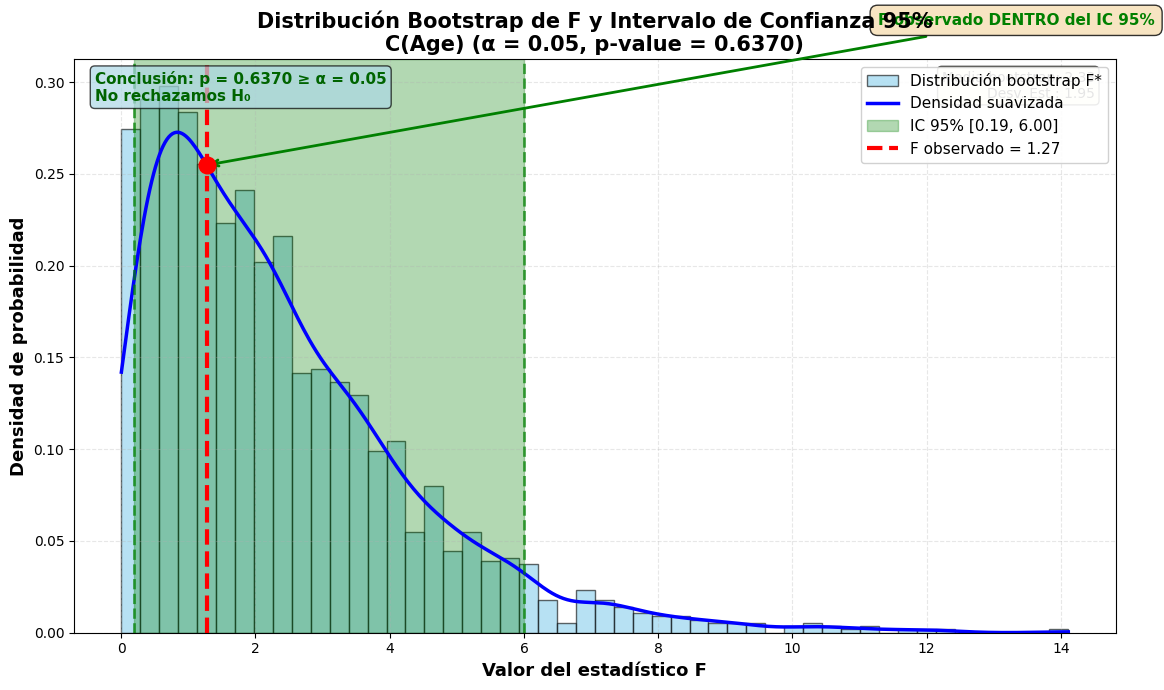

RESUMEN DEL ANÁLISIS BOOTSTRAP
Variable: C(Age)
Nivel de significancia (α): 0.05

Estadístico F observado: 1.271943

Distribución Bootstrap (B = 2000 remuestras):
  Media:        2.333164
  Mediana:      1.875963
  Desv. Est.:   1.950273
  Mínimo:       0.001505
  Máximo:       14.111341

Intervalo de Confianza 95%: [0.191175, 5.998343]
Ancho del IC: 5.807168

p-value bootstrap: 0.637000

Interpretación:
  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias
    significativas entre estados (p = 0.6370 ≥ 0.05)


In [52]:
# ========== GRÁFICO DE INTERVALO DE CONFIANZA Y F OBSERVADO (CAMPANA) ==========

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sp_stats

# Obtener valores del ANOVA bootstrap (celda 18)
term = "C(Age)"  # Variable de interés
f_obs_value = F_obs[term]  # F observado
ci_lower = ci[term][0]     # Límite inferior del IC
ci_upper = ci[term][1]     # Límite superior del IC
p_value = pB[term]         # p-value bootstrap

# Nivel de significancia (alpha = 0.05 según celda 18)
alpha = 0.05

# Obtener la distribución bootstrap de F*
f_star_values = np.array(Fstar[term], dtype=float)

# Crear figura
fig, ax = plt.subplots(figsize=(12, 7))

# ========== CAMPANA DE DISTRIBUCIÓN BOOTSTRAP ==========
# Calcular histograma
counts, bins, patches = ax.hist(f_star_values, bins=50, density=True, 
                                 alpha=0.6, color='skyblue', edgecolor='black', 
                                 label='Distribución bootstrap F*')

# Ajustar curva suavizada (KDE - Kernel Density Estimation)
from scipy.stats import gaussian_kde
kde = gaussian_kde(f_star_values)
x_range = np.linspace(f_star_values.min(), f_star_values.max(), 500)
density = kde(x_range)
ax.plot(x_range, density, 'b-', linewidth=2.5, label='Densidad suavizada')

# ========== INTERVALO DE CONFIANZA ==========
# Sombrear región del IC 95%
y_max = density.max() * 1.1
ax.axvspan(ci_lower, ci_upper, alpha=0.3, color='green', 
           label=f'IC 95% [{ci_lower:.2f}, {ci_upper:.2f}]')

# Líneas verticales para los límites del IC
ax.axvline(ci_lower, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(ci_upper, color='green', linestyle='--', linewidth=2, alpha=0.7)

# ========== F OBSERVADO ==========
ax.axvline(f_obs_value, color='red', linestyle='--', linewidth=3, 
           label=f'F observado = {f_obs_value:.2f}')

# Marcar F observado con un punto en la curva
f_obs_density = kde(f_obs_value)[0]
ax.plot(f_obs_value, f_obs_density, 'ro', markersize=12, zorder=5)

# ========== CONFIGURACIÓN DEL GRÁFICO ==========
ax.set_xlabel('Valor del estadístico F', fontsize=13, fontweight='bold')
ax.set_ylabel('Densidad de probabilidad', fontsize=13, fontweight='bold')
ax.set_title(f'Distribución Bootstrap de F y Intervalo de Confianza 95%\n{term} (α = {alpha}, p-value = {p_value:.4f})', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# ========== ANOTACIONES ==========
# Verificar si F obs está dentro o fuera del IC
if f_obs_value < ci_lower or f_obs_value > ci_upper:
    conclusion = "F observado FUERA del IC 95%"
    color_conclusion = 'red'
else:
    conclusion = "F observado DENTRO del IC 95%"
    color_conclusion = 'green'

# Anotación principal
ax.annotate(conclusion, 
            xy=(f_obs_value, f_obs_density), 
            xytext=(f_obs_value + 10, f_obs_density * 1.3),
            fontsize=11, fontweight='bold', color=color_conclusion,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color=color_conclusion, lw=2))

# Información estadística
info_text = f"Conclusión: "
if p_value < alpha:
    info_text += f"p = {p_value:.4f} < α = {alpha}\nRechazamos H₀"
    info_color = 'red'
else:
    info_text += f"p = {p_value:.4f} ≥ α = {alpha}\nNo rechazamos H₀"
    info_color = 'darkgreen'

ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
        fontsize=11, fontweight='bold', color=info_color,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Estadísticas adicionales
stats_text = f"Media bootstrap: {f_star_values.mean():.2f}\nDesv. Est.: {f_star_values.std():.2f}"
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

# ========== RESUMEN NUMÉRICO ==========
print("="*70)
print("RESUMEN DEL ANÁLISIS BOOTSTRAP")
print("="*70)
print(f"Variable: {term}")
print(f"Nivel de significancia (α): {alpha}")
print(f"\nEstadístico F observado: {f_obs_value:.6f}")
print(f"\nDistribución Bootstrap (B = {len(f_star_values)} remuestras):")
print(f"  Media:        {f_star_values.mean():.6f}")
print(f"  Mediana:      {np.median(f_star_values):.6f}")
print(f"  Desv. Est.:   {f_star_values.std():.6f}")
print(f"  Mínimo:       {f_star_values.min():.6f}")
print(f"  Máximo:       {f_star_values.max():.6f}")
print(f"\nIntervalo de Confianza 95%: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"Ancho del IC: {ci_upper - ci_lower:.6f}")
print(f"\np-value bootstrap: {p_value:.6f}")
print(f"\nInterpretación:")
if p_value < alpha:
    print(f"  ✗ Rechazamos H₀: Hay diferencias significativas entre estados")
    print(f"    en relación al colesterol LDL (p = {p_value:.4f} < {alpha})")
else:
    print(f"  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias")
    print(f"    significativas entre estados (p = {p_value:.4f} ≥ {alpha})")
print("="*70)

### Robusto

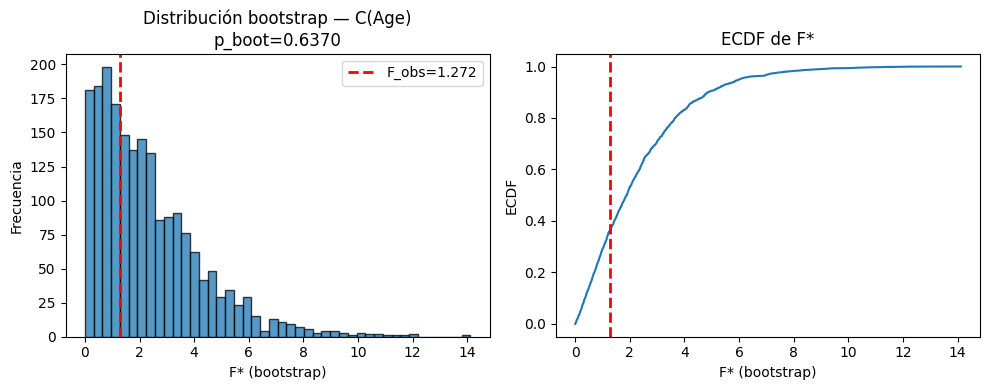

In [55]:
def plot_bootstrap_anova_robusto(term, F_obs, boot_dist, p_boot):
    vals = np.asarray(boot_dist[term], float)
    obs  = float(F_obs[term])
    p    = float(p_boot[term])

    B = len(vals)
    nunique = np.unique(vals).size
    nzeros  = np.sum(np.isclose(vals, 0))

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # — Histograma o gráfico de barras discreto si hay pocos únicos —
    if nunique <= 15:
        uniq, counts = np.unique(vals, return_counts=True)
        ax[0].bar(uniq, counts, width=0.08*(uniq.max()-uniq.min()+1) if uniq.size>1 else 0.5, edgecolor="k")
        ax[0].set_xlabel("F* (bootstrap)")
        ax[0].set_ylabel("Frecuencia")
    else:
        bins = max(10, min(50, int(np.sqrt(B))))
        ax[0].hist(vals, bins=bins, alpha=0.75, edgecolor='k')
        ax[0].set_xlabel("F* (bootstrap)")
        ax[0].set_ylabel("Frecuencia")

    ax[0].axvline(obs, color='red', linestyle='--', linewidth=2, label=f"F_obs={obs:.3f}")
    ax[0].legend()
    ax[0].set_title(f"Distribución bootstrap — {term}\np_boot={p:.4f}")

    # — ECDF (siempre informativa aunque haya empates) —
    x = np.sort(vals)
    y = np.arange(1, B+1)/B
    ax[1].plot(x, y)
    ax[1].axvline(obs, color='red', linestyle='--', linewidth=2)
    ax[1].set_xlabel("F* (bootstrap)")
    ax[1].set_ylabel("ECDF")
    ax[1].set_title("ECDF de F*")

    plt.tight_layout()
    plt.show()


# Ejemplo:
plot_bootstrap_anova_robusto("C(Age)", F_obs, Fstar, pB)

### MANOVA

In [56]:
# ========== MANOVA BOOTSTRAP ==========
terms, stat_obs, pB_manova, boot_distM, resM = bt.bootstrap_manova_percentil_bca(
    df=df,
    dvs=['CholesterolLDL','CholesterolHDL'],
    formula_rhs='C(Age)',
    group_cols=['Age'],
    n_resamples=1500,
    method="BCa",
    seed=7
)

# ========== MOSTRAR RESULTADOS ==========
print("="*70)
print("RESULTADOS MANOVA BOOTSTRAP (BCa)")
print("="*70)
print(f"\nVariables dependientes: {', '.join(['CholesterolLDL', 'CholesterolHDL'])}")
print(f"Factor: C(Age)")
print(f"Número de remuestras: 1500")
print(f"Método: BCa")
print(f"Nivel de significancia (α): 0.05")
print("\n" + "="*70)
print("TABLA DE RESULTADOS")
print("="*70)
display(resM)

# Interpretación
print("\n" + "="*70)
print("INTERPRETACIÓN")
print("="*70)

# Iterar solo sobre las claves que existen en stat_obs
for test_name in stat_obs.keys():
    if test_name in pB_manova:
        stat = stat_obs[test_name]
        p_val = pB_manova[test_name]
        
        print(f"\nEstadístico: {test_name}")
        
        # Si stat es un diccionario, mostrar todos los valores
        if isinstance(stat, dict):
            print(f"  Valores observados:")
            for key, val in stat.items():
                print(f"    {key}: {val:.6f}")
        else:
            print(f"  Valor observado: {stat:.6f}")
        
        # Mostrar p-value
        if isinstance(p_val, dict):
            print(f"  p-values bootstrap:")
            for key, val in p_val.items():
                print(f"    {key}: {val:.6f}")
        else:
            print(f"  p-value bootstrap: {p_val:.6f}")
        
        # Interpretación
        # Usar el primer p-value si es un diccionario
        p_to_check = list(p_val.values())[0] if isinstance(p_val, dict) else p_val
        
        if p_to_check < 0.05:
            print(f"  ✗ Rechazamos H₀: Hay diferencias significativas multivariadas")
            print(f"    entre estados (p < 0.05)")
        else:
            print(f"  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias")
            print(f"    significativas multivariadas entre estados (p ≥ 0.05)")

print("="*70)

RESULTADOS MANOVA BOOTSTRAP (BCa)

Variables dependientes: CholesterolLDL, CholesterolHDL
Factor: C(Age)
Número de remuestras: 1500
Método: BCa
Nivel de significancia (α): 0.05

TABLA DE RESULTADOS


BootstrapResult(confidence_interval=ConfidenceInterval(low=array([8.45652148e-05, 9.96661066e-01, 8.45759311e-05, 7.79524642e-05]), high=array([0.00333303, 0.99991543, 0.00335001, 0.00319166])), bootstrap_distribution=array([[0.00375323, 0.00520718, 0.00156951, ..., 0.00143333, 0.00663426,
        0.00209316],
       [0.99624986, 0.99479886, 0.99843054, ..., 0.99856667, 0.99337653,
        0.99790724],
       [0.00376116, 0.00522226, 0.00157188, ..., 0.00143539, 0.00665678,
        0.00209674],
       [0.00254157, 0.00347479, 0.00154097, ..., 0.00143488, 0.00380165,
        0.0018798 ]], shape=(4, 1500)), standard_error=array([0.00212739, 0.00212601, 0.00214433, 0.00199999]))


INTERPRETACIÓN

Estadístico: Pillai
  Valores observados:
    C(Age): 0.001395
  p-values bootstrap:
    C(Age): 1.000000
  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias
    significativas multivariadas entre estados (p ≥ 0.05)

Estadístico: Wilks
  Valores observados:
    C(Age): 0.998605
  p-values bootstrap:
    C(Age): 1.000000
  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias
    significativas multivariadas entre estados (p ≥ 0.05)

Estadístico: Roy
  Valores observados:
    C(Age): 0.001306
  p-values bootstrap:
    C(Age): 1.000000
  ✓ No rechazamos H₀: No hay evidencia suficiente de diferencias
    significativas multivariadas entre estados (p ≥ 0.05)


In [70]:
def mean_diff(a, b, axis=0):
    # diferencia de medias (a - b)
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

def welch_t(a, b, axis=0):
    # t de Welch: (m1-m2) / sqrt(s1^2/n1 + s2^2/n2)
    a = np.asarray(a); b = np.asarray(b)
    m1 = np.mean(a, axis=axis); m2 = np.mean(b, axis=axis)
    v1 = np.var(a, axis=axis, ddof=1); v2 = np.var(b, axis=axis, ddof=1)
    n1 = a.shape[axis];            n2 = b.shape[axis]
    se = np.sqrt(v1/n1 + v2/n2)
    return (m1 - m2) / se



# --- 0) Extrae las dos muestras (ajusta nombres de columnas/níveles) ---
x = df.loc[df["Gender"] == "1", "CholesterolLDL"].to_numpy()
y = df.loc[df["Gender"] == "0", "CholesterolLDL"].to_numpy()



diff_hat = mean_diff(x, y)                   # diferencia observada
t_obs    = welch_t(x, y)                     # t de Welch observado
# SE "de Welch" en la muestra original (lo usamos para bootstrap-t)
se_hat   = np.sqrt(np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y))

# --- 2) BCa para la DIFERENCIA DE MEDIAS (no paramétrico, i.i.d.) ---
#     Usamos directamente scipy.stats.bootstrap con method="BCa".
res_bca = bootstrap(
    data=(x, y),
    statistic=mean_diff,      # el estadístico es la diferencia de medias
    vectorized=False,
    paired=False,             # muestras independientes
    axis=0,
    n_resamples=5000,
    method="BCa",
    random_state=42
)
ci_bca_low, ci_bca_high = float(res_bca.confidence_interval.low), float(res_bca.confidence_interval.high)

# --- 3) Bootstrap-t (studentized) para la diferencia ---
#     Idea: generamos la distribución de t* (Welch) y tomamos sus percentiles.
#     Luego:  IC_t = diff_hat ± t*_(α/2, 1-α/2) × se_hat  (usando el SE de la muestra original)
res_t = bootstrap(
    data=(x, y),
    statistic=bt.welch_t,        # devolvemos t* directamente
    vectorized=False,
    paired=False,
    axis=0,
    n_resamples=5000,
    method="percentile",      # el método aquí solo afecta al CI de t*, que no usaremos
    random_state=43
)
t_star = res_t.bootstrap_distribution.ravel()
alpha = 0.05
tq_low, tq_high = np.quantile(t_star, [alpha/2, 1 - alpha/2])
ci_t_low  = float(diff_hat - tq_high * se_hat)   # ojo: invierte colas al reconstruir
ci_t_high = float(diff_hat - tq_low  * se_hat)

# --- 4) p-bootstrap (bilateral) usando t* ---
p_boot_two_sided = float(np.mean(np.abs(t_star) >= abs(t_obs)))

# --- 5) Imprime resultados claros ---
print("== Dos muestras (t de Welch) con bootstrap ==\n")
print(f"n_M = {len(x)}, n_F = {len(y)}")
print(f"Dif. de medias observada (M - F): {diff_hat:.4f}")
print(f"t de Welch observado:            {t_obs:.4f}\n")

print("IC 95% (BCa) para la DIFERENCIA de medias:")
print(f"[{ci_bca_low:.4f}, {ci_bca_high:.4f}]  (B = {len(res_bca.bootstrap_distribution)})\n")

print("IC 95% (Bootstrap-t) para la DIFERENCIA de medias:")
print(f"[{ci_t_low:.4f}, {ci_t_high:.4f}]     (B = {len(t_star)})\n")

print(f"p-bootstrap (bilateral) basado en |t*|: {p_boot_two_sided:.4f}")

# (Opcional) Conclusión automática
if p_boot_two_sided < 0.05:
    print("\nConclusión: diferencia significativa entre medias (α=0.05) según bootstrap.")
else:
    print("\nConclusión: no hay evidencia suficiente de diferencia entre medias (α=0.05) según bootstrap.")

ValueError: each sample in `data` must contain two or more observations along `axis`.

### FAMD

Eliminando columnas: ['Unnamed: 0.1', 'Unnamed: 0']

Valores faltantes por columna:
Age                         0
Gender                      0
FamilyHistoryAlzheimers     0
HeadInjury                  0
Diabetes                    0
CholesterolTotal            0
CholesterolLDL              0
CholesterolHDL              0
CholesterolTriglycerides    0
MMSE                        0
State                       0
dtype: int64

Dimensiones: (2149, 11)
Dimensiones después de limpiar: (2149, 11)

Tipos de datos:
Age                          object
Gender                        int64
FamilyHistoryAlzheimers       int64
HeadInjury                    int64
Diabetes                      int64
CholesterolTotal            float64
CholesterolLDL              float64
CholesterolHDL              float64
CholesterolTriglycerides    float64
MMSE                         object
State                        object
dtype: object

Verificando varianza en columnas numéricas:
✓ Gender: var = 0.2501
✓ FamilyHi

,Componente,Autovalor (λ),Inercia (%),Inercia acumulada (%)
0,1,7.7935,3.76,3.76
1,2,6.7612,3.27,7.03
2,3,4.2163,2.04,9.07
3,4,4.0807,1.97,11.04
4,5,4.0257,1.94,12.98


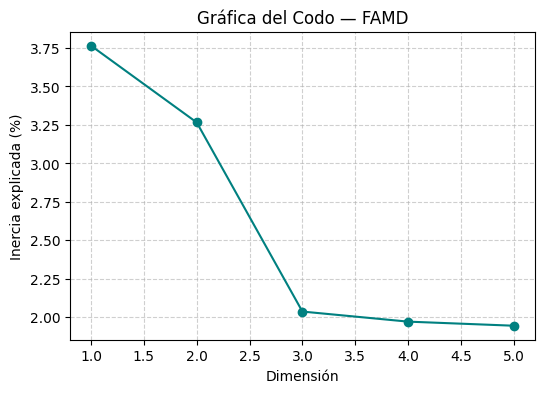

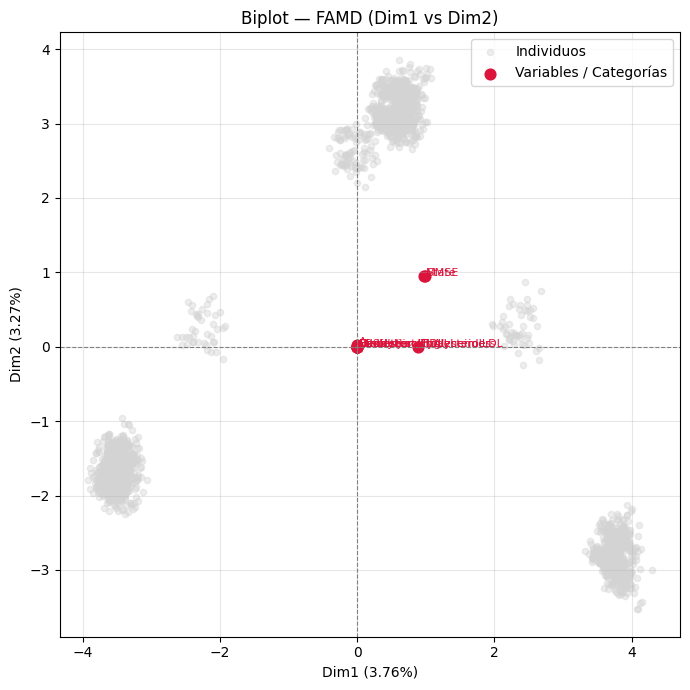

In [9]:
# Cargar datos
#df = pd.read_csv("Datos_RiesgoMetabolico.csv")

# --- Limpiar y preparar datos para FAMD ---
# 1. Eliminar columnas innecesarias (índices duplicados)
df_clean = df.copy()
cols_to_drop = [col for col in df_clean.columns if col.startswith('Unnamed:')]
if cols_to_drop:
    print(f"Eliminando columnas: {cols_to_drop}")
    df_clean = df_clean.drop(columns=cols_to_drop)

# 2. Verificar valores NaN
print("\nValores faltantes por columna:")
print(df_clean.isnull().sum())
print("\nDimensiones:", df_clean.shape)

# 3. Eliminar filas con valores faltantes si existen
df_clean = df_clean.dropna()
print("Dimensiones después de limpiar:", df_clean.shape)

# 4. Verificar tipos de datos
print("\nTipos de datos:")
print(df_clean.dtypes)

# 5. Verificar varianza en columnas numéricas
print("\nVerificando varianza en columnas numéricas:")
for col in df_clean.select_dtypes(include=[np.number]).columns:
    var = df_clean[col].var()
    if var == 0 or np.isnan(var):
        print(f"⚠️ Columna '{col}' tiene varianza cero o NaN: {var}")
    else:
        print(f"✓ {col}: var = {var:.4f}")

# --- Crear y ajustar el modelo FAMD ---
# Usar sklearn que es más robusto
n_comp = min(5, df_clean.shape[1] - 1)  # máximo 5 componentes

print(f"\nAjustando FAMD con {n_comp} componentes...")

famd = prince.FAMD(
    n_components=n_comp,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',            # sklearn es más robusto que scipy
    random_state=42
).fit(df_clean)

# --- Calcular autovalores e inercia ---
eigenvalues = np.array(famd.eigenvalues_)
var_exp = np.array(famd.percentage_of_variance_)     # varianza explicada por componente (%)
cum_var = np.cumsum(var_exp)                         # varianza acumulada (%)

# --- Mostrar resultados numéricos ---
print("\n" + "="*50)
print("RESULTADOS FAMD")
print("="*50)
print("\nAutovalores (λ):", np.round(eigenvalues, 4))
print("\nInercia explicada por componente (%):", np.round(var_exp, 2))
print("Inercia acumulada (%):", np.round(cum_var, 2))

# --- Tabla resumen ---
tabla_inercia = pd.DataFrame({
    "Componente": np.arange(1, len(eigenvalues)+1),
    "Autovalor (λ)": np.round(eigenvalues, 4),
    "Inercia (%)": np.round(var_exp, 2),
    "Inercia acumulada (%)": np.round(cum_var, 2)
})
display(tabla_inercia)

# --- Gráfica del codo ---
plt.figure(figsize=(6,4))
plt.plot(range(1, len(var_exp)+1), var_exp, marker='o', color='teal')
plt.title("Gráfica del Codo — FAMD")
plt.xlabel("Dimensión")
plt.ylabel("Inercia explicada (%)")
plt.grid(alpha=0.6, linestyle='--')
plt.show()

# --- 3.3.1 Biplot simplificado — solo puntos (sin flechas) ---

# Coordenadas de individuos (filas) y variables (columnas)
coords_individuos = famd.row_coordinates(df_clean)
coords_variables = famd.column_coordinates_

# Crear figura
plt.figure(figsize=(7,7))

# --- Individuos (puntos grises) ---
plt.scatter(
    coords_individuos[0], coords_individuos[1],
    alpha=0.4, color="lightgray", s=20, label="Individuos"
)

# --- Variables y categorías (puntos rojos) ---
plt.scatter(
    coords_variables[0], coords_variables[1],
    color="crimson", s=60, label="Variables / Categorías"
)

# Etiquetas de las variables / categorías
for i, txt in enumerate(coords_variables.index):
    plt.text(
        coords_variables.iloc[i, 0] + 0.02,
        coords_variables.iloc[i, 1],
        txt, fontsize=8, color="crimson"
    )

# Líneas guía en los ejes
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Etiquetas y formato
plt.title("Biplot — FAMD (Dim1 vs Dim2)")
plt.xlabel(f"Dim1 ({var_exp[0]:.2f}%)")
plt.ylabel(f"Dim2 ({var_exp[1]:.2f}%)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### K-Means

Columnas numéricas seleccionadas para K-means:
['Gender', 'FamilyHistoryAlzheimers', 'HeadInjury', 'Diabetes', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']

Dimensiones: (2149, 8)

Varianza explicada por PC1: 13.59%
Varianza explicada por PC2: 13.14%
Varianza total explicada: 26.72%


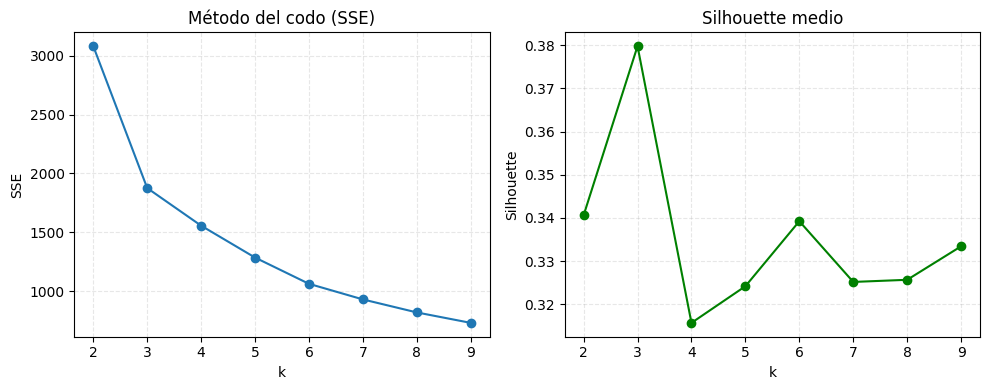


Silhouette score para k=3: 0.380


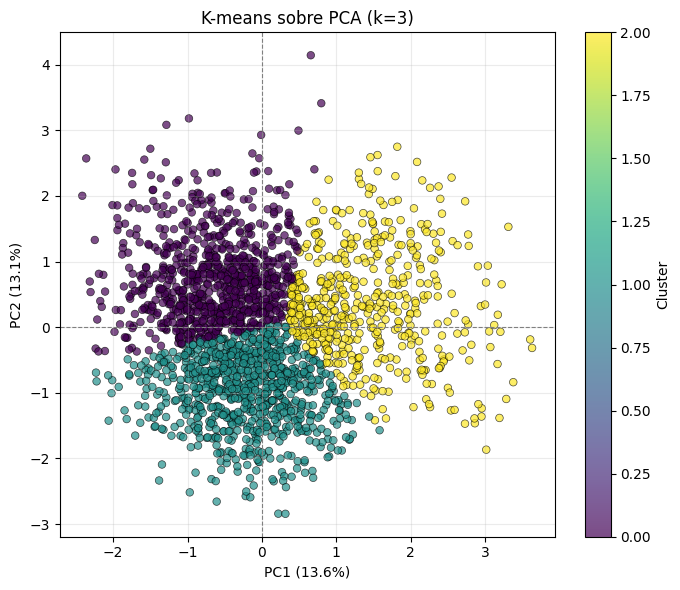


RESUMEN DE CLUSTERS

Tamaño de cada cluster (%):
0    37.92
1    38.48
2    23.59 

Promedios por variable en cada cluster:

         Gender  FamilyHistoryAlzheimers  HeadInjury  Diabetes  \
Cluster                                                          
0          0.67                     0.25        0.19      0.02   
1          0.41                     0.32        0.02      0.01   
2          0.41                     0.15        0.05      0.59   

         CholesterolTotal  CholesterolLDL  CholesterolHDL  \
Cluster                                                     
0                  216.50          148.95           46.97   
1                  219.71           94.54           67.59   
2                  248.14          133.36           66.30   

         CholesterolTriglycerides  
Cluster                            
0                          221.07  
1                          262.82  
2                          183.53  


<Figure size 1000x500 with 0 Axes>

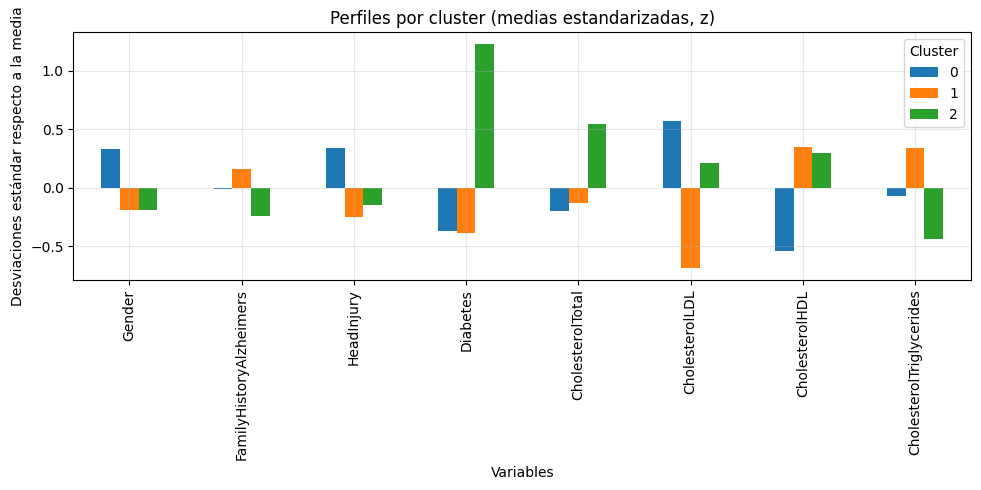


✓ Se agregó la columna 'Cluster' al dataframe


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- 0) Parámetros ----------
k_elegido = 3                                            # <- define k tras ver codo/silhouette

# ---------- 1) Preparar datos: solo variables numéricas ----------
# Eliminar columnas innecesarias y seleccionar solo numéricas
df_kmeans = df.copy()
cols_to_drop = [col for col in df_kmeans.columns if col.startswith('Unnamed:')]
if cols_to_drop:
    df_kmeans = df_kmeans.drop(columns=cols_to_drop)

# Seleccionar solo columnas numéricas
df_numeric = df_kmeans.select_dtypes(include=[np.number])
print("Columnas numéricas seleccionadas para K-means:")
print(list(df_numeric.columns))
print(f"\nDimensiones: {df_numeric.shape}")

# Convertir a array y estandarizar
X = df_numeric.values
Xz = StandardScaler().fit_transform(X)

# ---------- 2) PCA ----------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xz)
var_exp = pca.explained_variance_ratio_ * 100  # %

print(f"\nVarianza explicada por PC1: {var_exp[0]:.2f}%")
print(f"Varianza explicada por PC2: {var_exp[1]:.2f}%")
print(f"Varianza total explicada: {sum(var_exp):.2f}%")

# ---------- 3) Elección de k: Codo + Silhouette ----------
ks = range(2, 10)
sse, sil = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_pca)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_pca, km.labels_))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(ks), sse, marker='o')
ax[0].set_title("Método del codo (SSE)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("SSE"); ax[0].grid(alpha=.3, ls='--')
ax[1].plot(list(ks), sil, marker='o', color='green')
ax[1].set_title("Silhouette medio"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette"); ax[1].grid(alpha=.3, ls='--')
plt.tight_layout(); plt.show()

# ---------- 4) Ajustar K-means con k elegido ----------
km = KMeans(n_clusters=k_elegido, n_init=10, random_state=42).fit(X_pca)
labels = km.labels_
print(f"\nSilhouette score para k={k_elegido}: {silhouette_score(X_pca, labels):.3f}")

# ---------- 5) Dispersión PC1–PC2 coloreada por cluster ----------
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.axhline(0, color='gray', ls='--', lw=0.8); plt.axvline(0, color='gray', ls='--', lw=0.8)
plt.xlabel(f"PC1 ({var_exp[0]:.1f}%)"); plt.ylabel(f"PC2 ({var_exp[1]:.1f}%)")
plt.title(f"K-means sobre PCA (k={k_elegido})"); plt.grid(alpha=.25)
plt.tight_layout(); plt.show()

# ---------- 6) Resumen interpretativo ----------
# 6.1 Porcentaje por cluster
tam = (pd.Series(labels).value_counts(normalize=True)*100).sort_index().round(2)
print("\n" + "="*50)
print("RESUMEN DE CLUSTERS")
print("="*50)
print("\nTamaño de cada cluster (%):")
print(tam.to_string(), "\n")

# 6.2 Perfiles por cluster (medias en escala original)
df_perfil = df_numeric.copy(); df_perfil["Cluster"] = labels
perfil = df_perfil.groupby("Cluster").mean().round(2)
print("Promedios por variable en cada cluster:\n")
print(perfil)

# 6.3 Perfiles estandarizados (z) para comparar variables en una misma escala
mu, sigma = df_numeric.mean(), df_numeric.std(ddof=0)
perfil_z = ((perfil.drop('Cluster', axis=1, errors='ignore') - mu) / sigma).round(2)

# Gráfico de barras (perfiles z) para facilitar interpretación comparativa
plt.figure(figsize=(10, 5))
perfil_z.T.plot(kind='bar', figsize=(10, 5))
plt.title("Perfiles por cluster (medias estandarizadas, z)")
plt.ylabel("Desviaciones estándar respecto a la media")
plt.xlabel("Variables")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# ---------- 7) Guardar resultados (opcional) ----------
# Agregar cluster al dataframe original
df_with_clusters = df.copy()
df_with_clusters["Cluster"] = labels
print(f"\n✓ Se agregó la columna 'Cluster' al dataframe")
# df_with_clusters.to_csv("Resultados_PCA_KMeans.csv", index=False)

Dimensiones de coordenadas FAMD: (2149, 5)
Usando 5 componentes FAMD



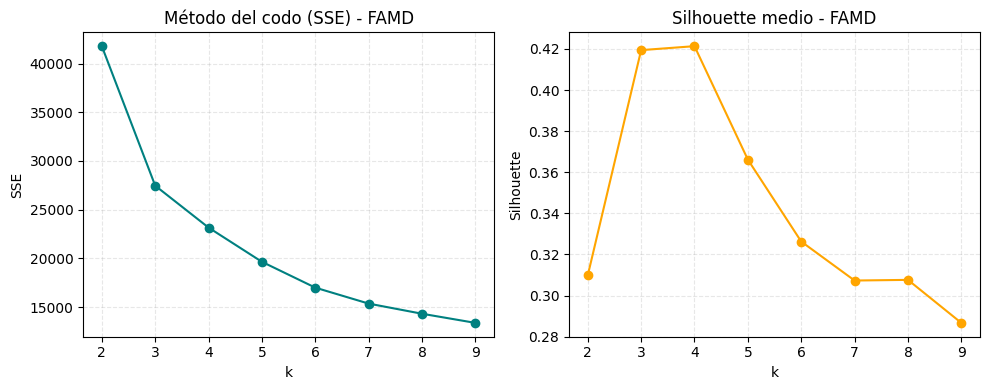

Silhouette scores por k:
  k=2: 0.3098
  k=3: 0.4194
  k=4: 0.4213
  k=5: 0.3662
  k=6: 0.3263
  k=7: 0.3073
  k=8: 0.3076
  k=9: 0.2867

K-means sobre FAMD con k=3
Silhouette score: 0.4194


K-means sobre FAMD con k=3
Silhouette score: 0.4194



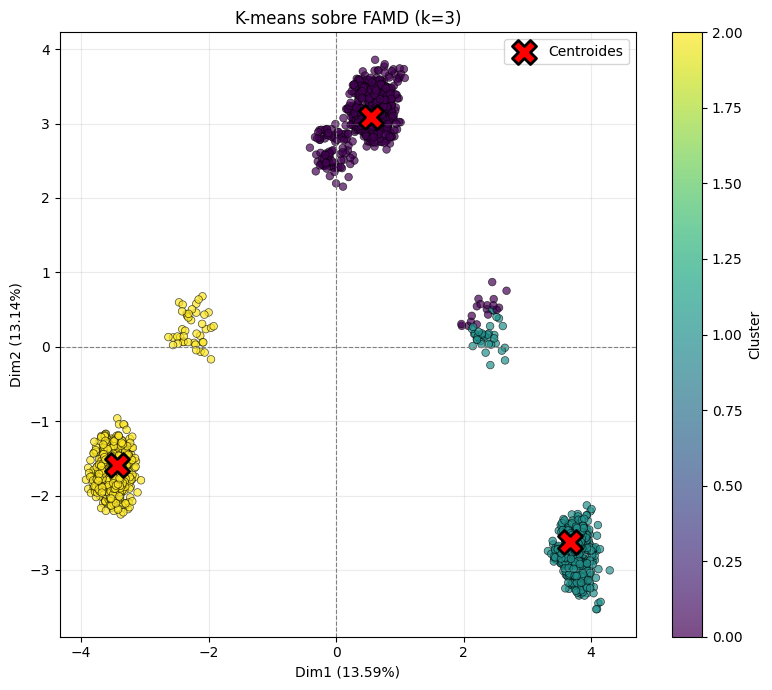


Tamaño de cada cluster (%):
0    39.79
1    26.06
2    34.16


Promedios de variables numéricas por cluster:
         Gender  FamilyHistoryAlzheimers  HeadInjury  Diabetes  \
Cluster                                                          
0          0.52                     0.26        0.11      0.14   
1          0.51                     0.22        0.09      0.17   
2          0.49                     0.26        0.08      0.15   

         CholesterolTotal  CholesterolLDL  CholesterolHDL  \
Cluster                                                     
0                  224.26          130.12           58.81   
1                  226.19          179.66           59.12   
2                  225.53           75.39           60.48   

         CholesterolTriglycerides  
Cluster                            
0                          226.17  
1                          229.46  
2                          229.84  


<Figure size 1000x500 with 0 Axes>

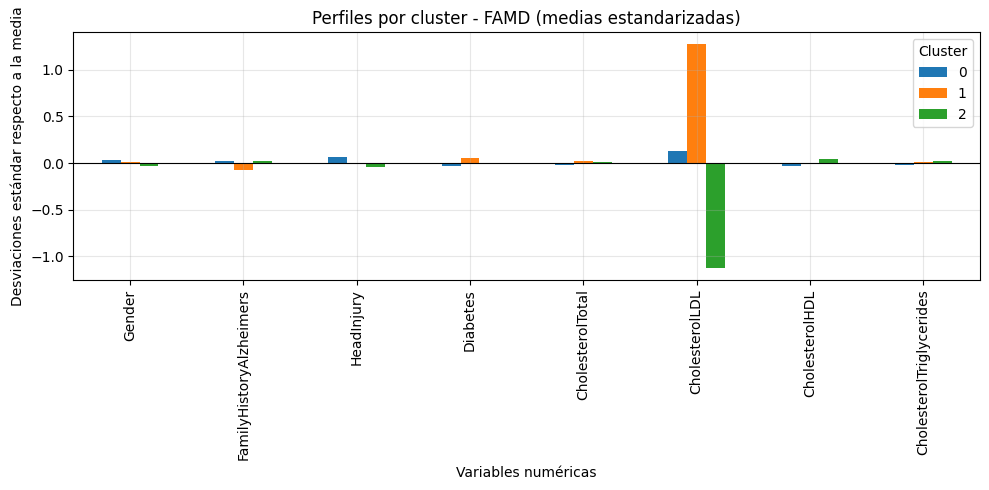



Distribución de variables categóricas por cluster:

Age:
Age      60-69  70-79  80-90
Cluster                     
0         29.9   31.0   39.1
1         35.7   32.9   31.4
2         33.4   34.6   32.0

MMSE:
MMSE     Demencia severa  Deterioro leve  Deterioro moderado  \
Cluster                                                        
0                    0.0            89.1                 0.0   
1                   51.6             6.1                42.3   
2                    0.0             0.0                 0.0   

MMSE     Posible deterioro  Sin deterioro  
Cluster                                    
0                     10.9            0.0  
1                      0.0            0.0  
2                      5.6           94.4  

State:
State    Alabama  Alaska  Arizona  Arkansas  California  Colorado  \
Cluster                                                             
0            0.0     0.0      6.7       0.6         0.0       0.0   
1           10.5     0.0      0.0

In [12]:
# ========== K-MEANS SOBRE COORDENADAS FAMD ==========

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- 0) Parámetros ----------
k_elegido_famd = 3  # <- ajusta después de ver codo/silhouette

# ---------- 1) Obtener coordenadas FAMD (ya calculadas anteriormente) ----------
# Usamos las coordenadas de los individuos en el espacio reducido FAMD
X_famd = famd.row_coordinates(df_clean).values  # convertir a numpy array
print(f"Dimensiones de coordenadas FAMD: {X_famd.shape}")
print(f"Usando {X_famd.shape[1]} componentes FAMD\n")

# ---------- 2) Elección de k: Codo + Silhouette ----------
ks = range(2, 10)
sse_famd, sil_famd = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_famd)
    sse_famd.append(km.inertia_)
    sil_famd.append(silhouette_score(X_famd, km.labels_))

# Gráficos de diagnóstico
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(ks), sse_famd, marker='o', color='teal')
ax[0].set_title("Método del codo (SSE) - FAMD")
ax[0].set_xlabel("k")
ax[0].set_ylabel("SSE")
ax[0].grid(alpha=.3, ls='--')

ax[1].plot(list(ks), sil_famd, marker='o', color='orange')
ax[1].set_title("Silhouette medio - FAMD")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette")
ax[1].grid(alpha=.3, ls='--')
plt.tight_layout()
plt.show()

# Mostrar valores de silhouette
print("Silhouette scores por k:")
for k, s in zip(ks, sil_famd):
    print(f"  k={k}: {s:.4f}")

# ---------- 3) Ajustar K-means con k elegido ----------
km_famd = KMeans(n_clusters=k_elegido_famd, n_init=10, random_state=42).fit(X_famd)
labels_famd = km_famd.labels_
sil_final = silhouette_score(X_famd, labels_famd)

print(f"\n{'='*50}")
print(f"K-means sobre FAMD con k={k_elegido_famd}")
print(f"{'='*50}")
print(f"Silhouette score: {sil_final:.4f}\n")

# ---------- 4) Visualización: Dispersión Dim1 vs Dim2 por cluster ----------
plt.figure(figsize=(8, 7))
scatter = plt.scatter(
    X_famd[:, 0], X_famd[:, 1], 
    c=labels_famd, 
    cmap='viridis', 
    s=30, 
    alpha=0.7, 
    edgecolors='k', 
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster')

# Centroides
centroids = km_famd.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', 
    marker='X', 
    s=300, 
    edgecolors='black', 
    linewidth=2,
    label='Centroides',
    zorder=5
)

plt.axhline(0, color='gray', ls='--', lw=0.8)
plt.axvline(0, color='gray', ls='--', lw=0.8)
plt.xlabel(f"Dim1 ({var_exp[0]:.2f}%)")
plt.ylabel(f"Dim2 ({var_exp[1]:.2f}%)")
plt.title(f"K-means sobre FAMD (k={k_elegido_famd})")
plt.legend()
plt.grid(alpha=.25)
plt.tight_layout()
plt.show()

# ---------- 5) Resumen interpretativo ----------
# 5.1 Tamaño de clusters
tam_famd = (pd.Series(labels_famd).value_counts(normalize=True)*100).sort_index().round(2)
print("\nTamaño de cada cluster (%):")
print(tam_famd.to_string())

# 5.2 Perfiles por cluster (solo variables numéricas originales)
df_numeric_clean = df_clean.select_dtypes(include=[np.number])
df_perfil_famd = df_numeric_clean.copy()
df_perfil_famd["Cluster"] = labels_famd

perfil_famd = df_perfil_famd.groupby("Cluster").mean().round(2)
print("\n\nPromedios de variables numéricas por cluster:")
print(perfil_famd)

# 5.3 Perfiles estandarizados
mu_famd = df_numeric_clean.mean()
sigma_famd = df_numeric_clean.std(ddof=0)
perfil_z_famd = ((perfil_famd - mu_famd) / sigma_famd).round(2)

# Gráfico de perfiles
plt.figure(figsize=(10, 5))
perfil_z_famd.T.plot(kind='bar', figsize=(10, 5))
plt.title("Perfiles por cluster - FAMD (medias estandarizadas)")
plt.ylabel("Desviaciones estándar respecto a la media")
plt.xlabel("Variables numéricas")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(alpha=.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 5.4 Distribución de variables categóricas por cluster
print("\n\nDistribución de variables categóricas por cluster:")
df_cat_clean = df_clean.select_dtypes(include=['object', 'category'])
df_cat_clean["Cluster"] = labels_famd

for col in df_cat_clean.columns:
    if col != "Cluster":
        print(f"\n{col}:")
        ct = pd.crosstab(df_cat_clean["Cluster"], df_cat_clean[col], normalize='index')
        print((ct * 100).round(1))

# ---------- 6) Guardar resultados (opcional) ----------
df_famd_clusters = df_clean.copy()
df_famd_clusters["Cluster_FAMD"] = labels_famd
print(f"\n✓ Se agregó la columna 'Cluster_FAMD' al dataframe")
# df_famd_clusters.to_csv("Resultados_FAMD_KMeans.csv", index=False)

In [20]:
print(df_famd_clusters[["CholesterolLDL","State", "MMSE","Cluster_FAMD"]])
#df_famd_clusters.to_csv(Path("Resultados_FAMD_KMeans.csv"), index=False)

      CholesterolLDL       State             MMSE  Cluster_FAMD
0          56.150897  California    Sin deterioro             2
1         193.407995    Arkansas  Demencia severa             1
2         153.322762    Nebraska   Deterioro leve             0
3          65.366637     Vermont    Sin deterioro             2
4          92.869700  California    Sin deterioro             2
...              ...         ...              ...           ...
2144       94.870490        Utah    Sin deterioro             2
2145       95.410700     Montana    Sin deterioro             2
2146      156.267294     Indiana   Deterioro leve             0
2147       52.482961      Alaska    Sin deterioro             2
2148       92.200064      Hawaii    Sin deterioro             2

[2149 rows x 4 columns]


Tabla de contingencia (Estados x Clusters):
Cluster_FAMD     0   1   2
State                     
Alabama          0  59   0
Alaska           0   0  51
Arizona         57   0   0
Arkansas         5  41   0
California       0   0  35
Colorado         0   0  37
Connecticut      0   0  44
Delaware         2  47   0
Florida         49   0   0
Georgia         43   0   0
Hawaii           0   0  26
Idaho           51   0   0
Illinois        51   0   0
Indiana         52   0   0
Iowa            43   0   0
Kansas          38   0   0
Kentucky         0  54   0
Louisiana        0  46   0
Maine           43   0   0
Maryland         0   0  29
Massachusetts    0   0  25
Michigan        53   0   0
Minnesota        0   0  37
Mississippi      1  50   0
Missouri         0  44   0
Montana          0   0  38
Nebraska        59   0   0
Nevada          48   0   0
New Hampshire   60   0   0
New Mexico      48   0   0
New York         0   0  39
North Carolina  53   0   0
North Dakota     0   0  48
Ohio       

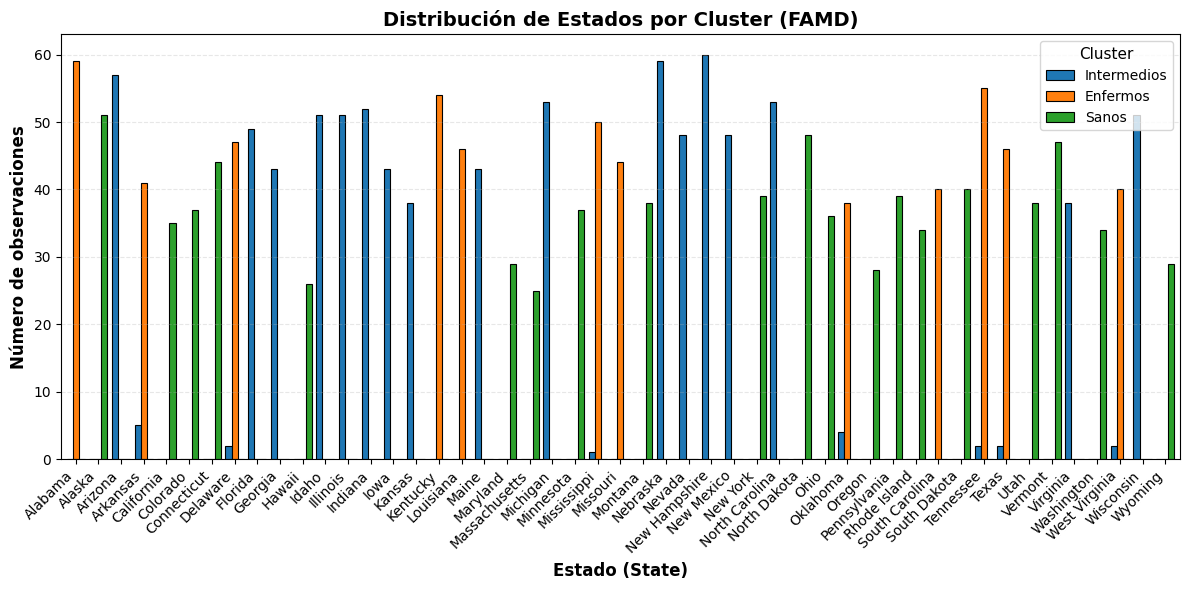


Distribución porcentual por Estado (% dentro de cada cluster):
                Intermedios  Enfermos  Sanos
State                                       
Alabama                0.00     10.54   0.00
Alaska                 0.00      0.00   6.95
Arizona                6.67      0.00   0.00
Arkansas               0.58      7.32   0.00
California             0.00      0.00   4.77
Colorado               0.00      0.00   5.04
Connecticut            0.00      0.00   5.99
Delaware               0.23      8.39   0.00
Florida                5.73      0.00   0.00
Georgia                5.03      0.00   0.00
Hawaii                 0.00      0.00   3.54
Idaho                  5.96      0.00   0.00
Illinois               5.96      0.00   0.00
Indiana                6.08      0.00   0.00
Iowa                   5.03      0.00   0.00
Kansas                 4.44      0.00   0.00
Kentucky               0.00      9.64   0.00
Louisiana              0.00      8.21   0.00
Maine                  5.03      0.0

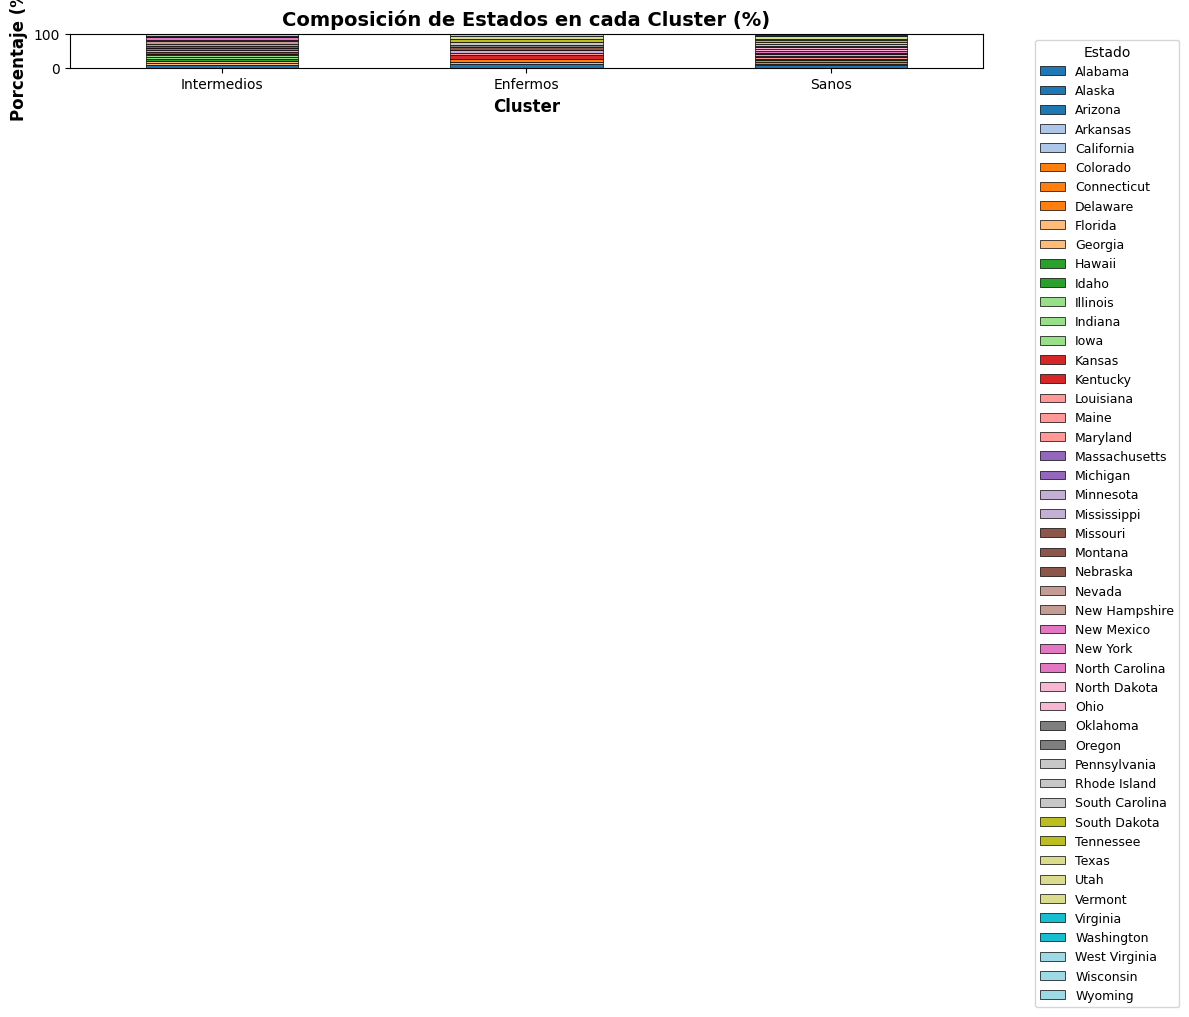

In [21]:
# ========== GRÁFICO DE BARRAS: ESTADOS POR CLUSTER ==========

# Nombres personalizables para cada cluster
cluster_names = {
    0: "Intermedios",  # <- Modifica aquí el nombre del cluster 0
    1: "Enfermos",  # <- Modifica aquí el nombre del cluster 1
    2: "Sanos"   # <- Modifica aquí el nombre del cluster 2
}

# Crear tabla de contingencia: Estados (filas) x Clusters (columnas)
contingency = pd.crosstab(df_famd_clusters["State"], df_famd_clusters["Cluster_FAMD"])
print("Tabla de contingencia (Estados x Clusters):")
print(contingency)
print("\n")

# Renombrar columnas con nombres personalizados
contingency.columns = [cluster_names.get(i, f"Cluster {i}") for i in contingency.columns]

# Configurar la figura
fig, ax = plt.subplots(figsize=(12, 6))

# Crear gráfico de barras agrupadas
contingency.plot(
    kind='bar',
    ax=ax,
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Colores personalizables
    edgecolor='black',
    linewidth=0.8
)

# Personalizar el gráfico
ax.set_xlabel("Estado (State)", fontsize=12, fontweight='bold')
ax.set_ylabel("Número de observaciones", fontsize=12, fontweight='bold')
ax.set_title("Distribución de Estados por Cluster (FAMD)", fontsize=14, fontweight='bold')
ax.legend(title='Cluster', title_fontsize=11, fontsize=10, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Ajustar diseño
plt.tight_layout()
plt.show()

# ---------- Tabla resumen con porcentajes ----------
print("\nDistribución porcentual por Estado (% dentro de cada cluster):")
contingency_pct = pd.crosstab(
    df_famd_clusters["State"], 
    df_famd_clusters["Cluster_FAMD"], 
    normalize='columns'
) * 100

contingency_pct.columns = [cluster_names.get(i, f"Cluster {i}") for i in contingency_pct.columns]
print(contingency_pct.round(2))

# ---------- Gráfico adicional: Barras apiladas 100% ----------
fig2, ax2 = plt.subplots(figsize=(12, 6))

contingency_pct.T.plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    colormap='tab20',
    edgecolor='black',
    linewidth=0.5
)

ax2.set_xlabel("Cluster", fontsize=12, fontweight='bold')
ax2.set_ylabel("Porcentaje (%)", fontsize=12, fontweight='bold')
ax2.set_title("Composición de Estados en cada Cluster (%)", fontsize=14, fontweight='bold')
ax2.legend(title='Estado', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Tabla de contingencia (Estados x MMSE):
MMSE            Demencia severa  Deterioro leve  Deterioro moderado  \
State                                                                 
Alabama                      32               6                  21   
Alaska                        0               0                   0   
Arizona                       0              50                   0   
Arkansas                     20               6                  20   
California                    0               0                   0   
Colorado                      0               0                   0   
Connecticut                   0               0                   0   
Delaware                     24               5                  20   
Florida                       0              45                   0   
Georgia                       0              39                   0   
Hawaii                        0               0                   0   
Idaho                         0      

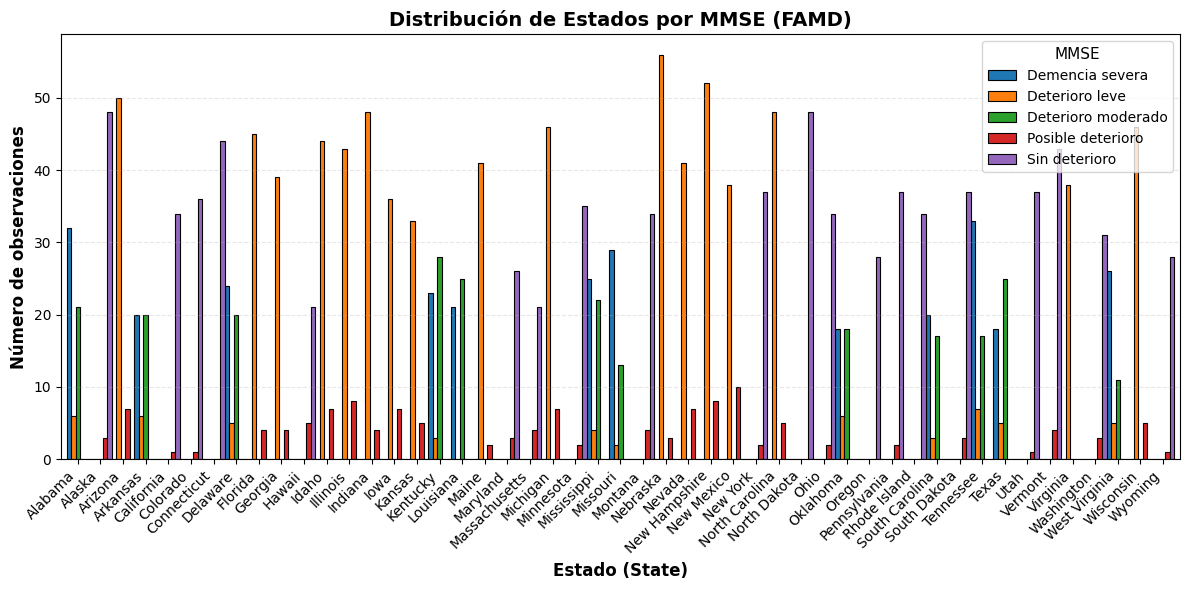


Distribución porcentual por Estado (% dentro de cada MMSE):
                Demencia severa  Deterioro leve  Deterioro moderado  \
State                                                                 
Alabama                   11.07            0.75                8.86   
Alaska                     0.00            0.00                0.00   
Arizona                    0.00            6.28                0.00   
Arkansas                   6.92            0.75                8.44   
California                 0.00            0.00                0.00   
Colorado                   0.00            0.00                0.00   
Connecticut                0.00            0.00                0.00   
Delaware                   8.30            0.63                8.44   
Florida                    0.00            5.65                0.00   
Georgia                    0.00            4.90                0.00   
Hawaii                     0.00            0.00                0.00   
Idaho           

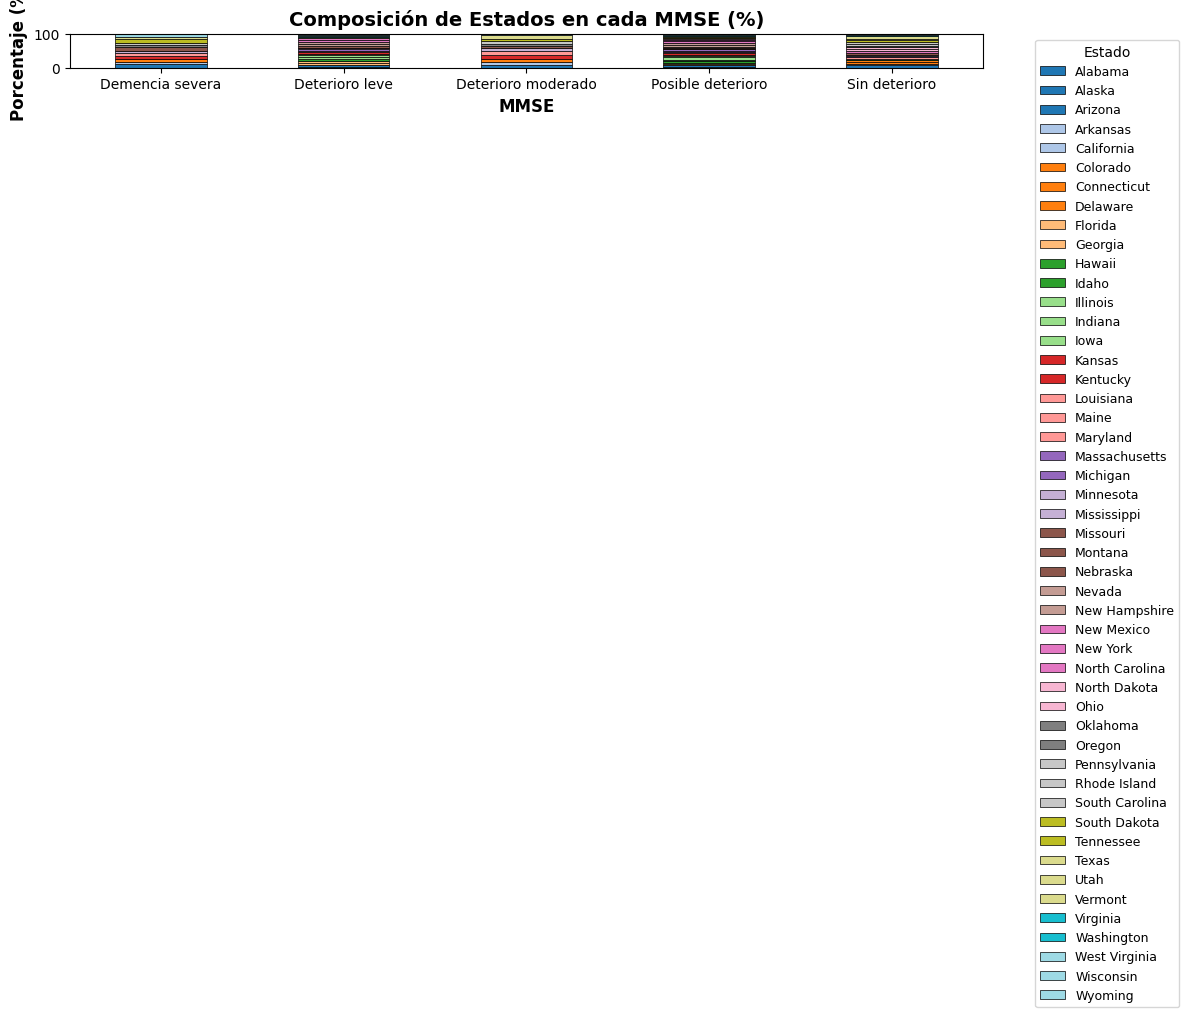

In [27]:
# ========== GRÁFICO DE BARRAS: ESTADOS POR CLUSTER ==========

# Nombres personalizables para cada cluster
cluster_names = {
    0: "Intermedios",  # <- Modifica aquí el nombre del cluster 0
    1: "Enfermos",  # <- Modifica aquí el nombre del cluster 1
    2: "Sanos"   # <- Modifica aquí el nombre del cluster 2
}

# Crear tabla de contingencia: Estados (filas) x Clusters (columnas)
contingency = pd.crosstab(df_famd_clusters["State"], df_famd_clusters["MMSE"])
print("Tabla de contingencia (Estados x MMSE):")
print(contingency)
print("\n")

# Renombrar columnas con nombres personalizados
contingency.columns = [cluster_names.get(i, f"{i}") for i in contingency.columns]

# Configurar la figura
fig, ax = plt.subplots(figsize=(12, 6))

# Crear gráfico de barras agrupadas
# 5 colores para las 5 categorías de MMSE
colores_mmse = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # azul, naranja, verde, rojo, morado
contingency.plot(
    kind='bar',
    ax=ax,
    width=1,
    color=colores_mmse,
    edgecolor='black',
    linewidth=0.8
)

# Personalizar el gráfico
ax.set_xlabel("Estado (State)", fontsize=12, fontweight='bold')
ax.set_ylabel("Número de observaciones", fontsize=12, fontweight='bold')
ax.set_title("Distribución de Estados por MMSE (FAMD)", fontsize=14, fontweight='bold')
ax.legend(title='MMSE', title_fontsize=11, fontsize=10, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Ajustar diseño
plt.tight_layout()
plt.show()

# ---------- Tabla resumen con porcentajes ----------
print("\nDistribución porcentual por Estado (% dentro de cada MMSE):")
contingency_pct = pd.crosstab(
    df_famd_clusters["State"], 
    df_famd_clusters["MMSE"], 
    normalize='columns'
) * 100

contingency_pct.columns = [cluster_names.get(i, f"{i}") for i in contingency_pct.columns]
print(contingency_pct.round(2))

# ---------- Gráfico adicional: Barras apiladas 100% ----------
fig2, ax2 = plt.subplots(figsize=(12, 6))

contingency_pct.T.plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    colormap='tab20',
    edgecolor='black',
    linewidth=0.5
)

ax2.set_xlabel("MMSE", fontsize=12, fontweight='bold')
ax2.set_ylabel("Porcentaje (%)", fontsize=12, fontweight='bold')
ax2.set_title("Composición de Estados en cada MMSE (%)", fontsize=14, fontweight='bold')
ax2.legend(title='Estado', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
# ========== DICCIONARIO: ESTADO → CLUSTER DOMINANTE ==========

# Nombres de clusters
cluster_names = {
    0: "Intermedios",
    1: "Enfermos",
    2: "Sanos"
}

# Crear tabla de contingencia: Estados x Clusters
contingency_estados = pd.crosstab(df_famd_clusters["State"], df_famd_clusters["Cluster_FAMD"])
print("Tabla de contingencia (Estados x Clusters):")
print(contingency_estados)
print("\n")

# Para cada estado, determinar el cluster con mayor cantidad de observaciones
estado_a_cluster = {}

for estado in contingency_estados.index:
    # Obtener el número del cluster con más observaciones para este estado
    cluster_dominante_num = contingency_estados.loc[estado].idxmax()
    
    # Convertir el número a nombre
    cluster_dominante_nombre = cluster_names[cluster_dominante_num]
    
    # Guardar en el diccionario
    estado_a_cluster[estado] = cluster_dominante_nombre

# Mostrar el diccionario
print("Diccionario Estado → Cluster Dominante:")
print("="*50)
for estado, cluster in sorted(estado_a_cluster.items()):
    count = contingency_estados.loc[estado, list(cluster_names.keys())].max()
    total = contingency_estados.loc[estado].sum()
    porcentaje = (count / total) * 100
    print(f"{estado:30} → {cluster:15} ({count}/{total} = {porcentaje:.1f}%)")

print("\n")
print("Diccionario completo:")
print(estado_a_cluster)

Tabla de contingencia (Estados x Clusters):
Cluster_FAMD     0   1   2
State                     
Alabama          0  59   0
Alaska           0   0  51
Arizona         57   0   0
Arkansas         5  41   0
California       0   0  35
Colorado         0   0  37
Connecticut      0   0  44
Delaware         2  47   0
Florida         49   0   0
Georgia         43   0   0
Hawaii           0   0  26
Idaho           51   0   0
Illinois        51   0   0
Indiana         52   0   0
Iowa            43   0   0
Kansas          38   0   0
Kentucky         0  54   0
Louisiana        0  46   0
Maine           43   0   0
Maryland         0   0  29
Massachusetts    0   0  25
Michigan        53   0   0
Minnesota        0   0  37
Mississippi      1  50   0
Missouri         0  44   0
Montana          0   0  38
Nebraska        59   0   0
Nevada          48   0   0
New Hampshire   60   0   0
New Mexico      48   0   0
New York         0   0  39
North Carolina  53   0   0
North Dakota     0   0  48
Ohio       

In [34]:
# ========== DICCIONARIO: ESTADO → CATEGORÍA MMSE DOMINANTE ==========

# Crear tabla de contingencia: Estados x MMSE
contingency_mmse = pd.crosstab(df_famd_clusters["State"], df_famd_clusters["MMSE"])
print("Tabla de contingencia (Estados x MMSE):")
print(contingency_mmse)
print("\n")

# Para cada estado, determinar la categoría MMSE con mayor cantidad de observaciones
estado_a_mmse = {}

for estado in contingency_mmse.index:
    # Obtener la categoría MMSE con más observaciones para este estado
    mmse_dominante = contingency_mmse.loc[estado].idxmax()
    
    # Guardar en el diccionario
    estado_a_mmse[estado] = mmse_dominante

# Mostrar el diccionario
print("Diccionario Estado → Categoría MMSE Dominante:")
print("="*50)
for estado, mmse in sorted(estado_a_mmse.items()):
    count = contingency_mmse.loc[estado, mmse]
    total = contingency_mmse.loc[estado].sum()
    porcentaje = (count / total) * 100
    print(f"{estado:30} → {mmse:25} ({count}/{total} = {porcentaje:.1f}%)")

print("\n")
print("Diccionario completo:")
print(estado_a_mmse)


Tabla de contingencia (Estados x MMSE):
MMSE            Demencia severa  Deterioro leve  Deterioro moderado  \
State                                                                 
Alabama                      32               6                  21   
Alaska                        0               0                   0   
Arizona                       0              50                   0   
Arkansas                     20               6                  20   
California                    0               0                   0   
Colorado                      0               0                   0   
Connecticut                   0               0                   0   
Delaware                     24               5                  20   
Florida                       0              45                   0   
Georgia                       0              39                   0   
Hawaii                        0               0                   0   
Idaho                         0      

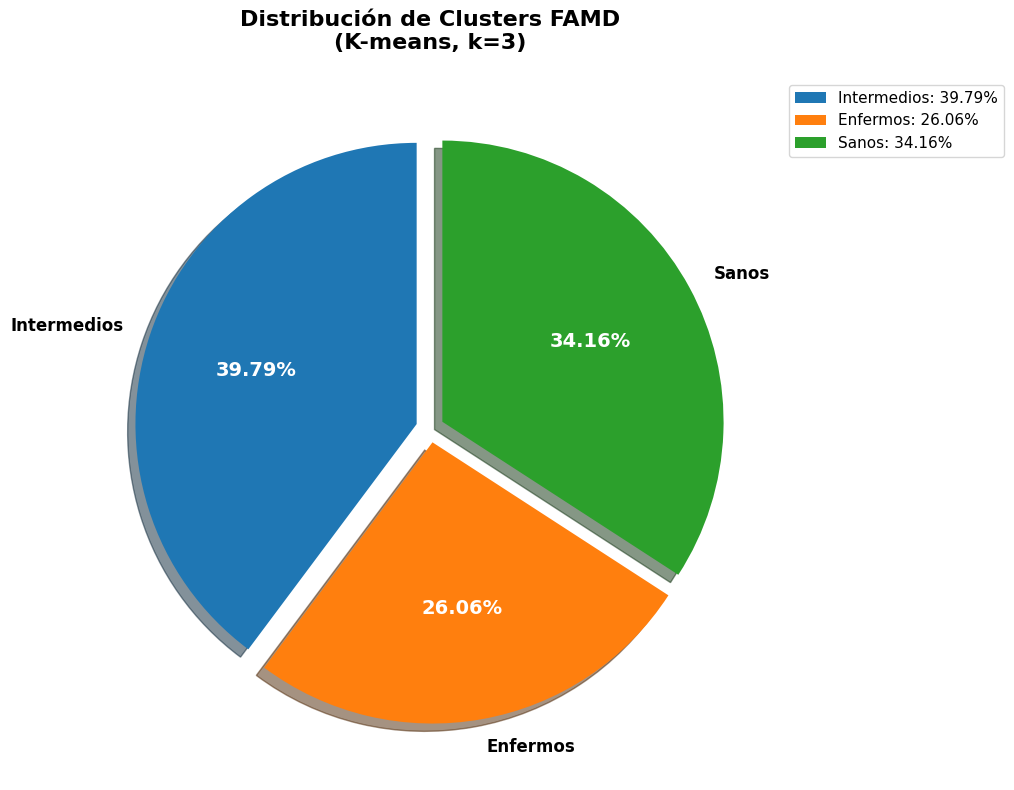

DISTRIBUCIÓN DE CLUSTERS
Cluster 0 (Intermedios    ):  39.79%
Cluster 1 (Enfermos       ):  26.06%
Cluster 2 (Sanos          ):  34.16%
Total: 100.01%


In [57]:
# ========== GRÁFICO DE PASTEL: DISTRIBUCIÓN DE CLUSTERS ==========

import matplotlib.pyplot as plt

# Datos
clusters = [0, 1, 2]
porcentajes = [39.79, 26.06, 34.16]
labels = ['Intermedios', 'Enfermos', 'Sanos']
colores = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Azul, naranja, verde

# Crear figura
fig, ax = plt.subplots(figsize=(10, 8))

# Crear gráfico de pastel
wedges, texts, autotexts = ax.pie(
    porcentajes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=90,
    colors=colores,
    explode=(0.05, 0.05, 0.05),  # Separar ligeramente las secciones
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Mejorar el formato de los porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Título
ax.set_title('Distribución de Clusters FAMD\n(K-means, k=3)', 
             fontsize=16, fontweight='bold', pad=20)

# Leyenda con información adicional
legend_labels = [f'{label}: {pct:.2f}%' for label, pct in zip(labels, porcentajes)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)

plt.tight_layout()
plt.show()

# ========== RESUMEN NUMÉRICO ==========
print("="*50)
print("DISTRIBUCIÓN DE CLUSTERS")
print("="*50)
for cluster_id, label, pct in zip(clusters, labels, porcentajes):
    print(f"Cluster {cluster_id} ({label:15}): {pct:6.2f}%")
print("="*50)
print(f"Total: {sum(porcentajes):.2f}%")
print("="*50)
